In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [118]:
mapping=pd.read_csv('comments_employee_mapping.csv').dropna()
likes=pd.read_csv('comments_likeability.csv').dropna()
attr=pd.read_csv('employee_attrition.csv').dropna()
hap=pd.read_csv('happiness_level.csv').dropna()

attr['lastParticipationDate']=pd.to_datetime(attr['lastParticipationDate'],infer_datetime_format=True)
mapping['commentDate']=pd.to_datetime(mapping['commentDate'],infer_datetime_format=True)
hap['voteDate']=pd.to_datetime(hap['voteDate'],infer_datetime_format=True)

In [184]:
attr['ordinal']=[x.toordinal() for x in attr['lastParticipationDate']]
mapping['ordinal']=[x.toordinal() for x in mapping['commentDate']]
hap['ordinal']=[x.toordinal() for x in hap['voteDate']]

/Users/vaibhavnayel/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
print mapping.shape
print likes.shape
print attr.shape
print hap.shape

(77329, 4)
(324478, 5)
(4418, 5)
(221232, 4)


## How many companies show up in the data?

In [34]:
print mapping['companyAlias'].unique().shape
print likes['companyAlias'].unique().shape
print attr['companyAlias'].unique().shape
print hap['companyAlias'].unique().shape

(36,)
(34,)
(37,)
(37,)


Each csv has a different number of companies. might have to exclude this column from analysis

## How many unique companies exist overall?

In [45]:
len(set(np.hstack([mapping['companyAlias'].unique(),
           likes['companyAlias'].unique(),
           attr['companyAlias'].unique(),
           hap['companyAlias'].unique()])))

37

Since the superset is size 37, attr and hap contain all the companies but there are 3 companies whose employees don't like any comments and 1 company whose employees don't make any comments. So there's a company where people are making comments but nobody is liking them? weird.

This means our model will need to handle inputs which have no likes or comments.

In [50]:
companies=hap['companyAlias'].unique() #list of all companies

## How many employees in each company?

company stats:
56aec740f1ef260003e307d6 353
54d43612e4b0f6a40755d93e 21
5370af43e4b0cff95558c12a 224
57bb2f0b3bae540003a8d453 135
567011c035dce00003a07fa4 165
5809cc9eff2ea40003fda44d 76
552e2d00e4b066b42fd122ed 29
581b08041a0ef8000308aef6 140
574c423856b6300003009953 139
57908a2622881200033b34d7 48
54e52607e4b01191dc064966 585
57dd2d6a4018d9000339ca43 221
57d979b72a040a00036a8925 18
5641f96713664c000332c8cd 224
58b471b384db3200044dd1b9 14
56fd2b64f41c670003f643c8 75
5474b9cde4b0bf7614b2c66f 10
56558cfd07a5de00030908fb 12
57c4aa7dbb8b5c000396fd3b 48
56e2a905e3b6fe0003e32855 101
57fcf18712cdbd000396e310 24
57d1eb86a22c9d0003dd1f05 50
574c5ade56b6300003009965 293
58c6e15f32f72a00046f556c 60
53a2dd43e4b01cc02f1e9011 144
573f2c4a3517490003ef7710 67
58b9adfce75bf80004df6536 21
56ae7b02f1ef260003e3072c 20
56ab28dc1f385d0003454757 34
57ac8b23be7fe30003e656d0 259
5742d699f839a10003a407d2 194
57d956302a040a00036a8905 171
57e518026d641600035db88a 9
5809cde3ff2ea40003fda452 44
58bf03e5cff4fa0004d

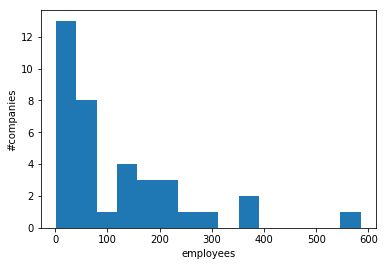

In [78]:
h=[]
print 'company stats:'
for company in companies:
    h.append((attr['companyAlias']==company).sum())
    print company,h[-1]
print 'total employees in system: ',attr.shape[0]
print 'avg employees per company: ', attr.shape[0]/37.0
plt.hist(h,bins=15);
plt.xlabel('employees');
plt.ylabel('#companies');

There are a lot of companies with less than 50 employees, so we should look into techniques that don't require a lot of data per company, or consider merging the companies

## what is the split of employees still working and those who left?

 overall still working: 3673, left: 745
company: 56aec740f1ef260003e307d6, working: 325, left: 28, attrition rate: 0.0793201133144
company: 54d43612e4b0f6a40755d93e, working: 14, left: 7, attrition rate: 0.333333333333
company: 5370af43e4b0cff95558c12a, working: 51, left: 173, attrition rate: 0.772321428571
company: 57bb2f0b3bae540003a8d453, working: 131, left: 4, attrition rate: 0.0296296296296
company: 567011c035dce00003a07fa4, working: 154, left: 11, attrition rate: 0.0666666666667
company: 5809cc9eff2ea40003fda44d, working: 76, left: 0, attrition rate: 0.0
company: 552e2d00e4b066b42fd122ed, working: 25, left: 4, attrition rate: 0.137931034483
company: 581b08041a0ef8000308aef6, working: 133, left: 7, attrition rate: 0.05
company: 574c423856b6300003009953, working: 118, left: 21, attrition rate: 0.151079136691
company: 57908a2622881200033b34d7, working: 37, left: 11, attrition rate: 0.229166666667
company: 54e52607e4b01191dc064966, working: 297, left: 288, attrition rate: 0.492307692

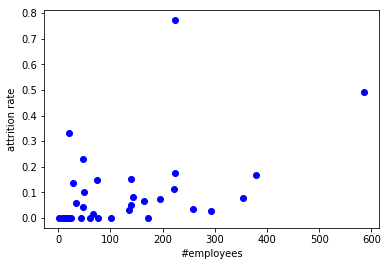

correlation coefficient:  0.47252133218050585


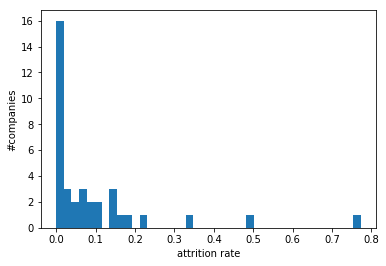

In [103]:
print ' overall still working: {}, left: {}'.format((attr['stillExists']==True).sum(),(attr['stillExists']==False).sum())
a=[]
for company in companies:
    working=(attr[attr['companyAlias']==company]['stillExists']==True).sum()
    left=(attr[attr['companyAlias']==company]['stillExists']==False).sum()
    print 'company: {}, working: {}, left: {}, attrition rate: {}'.format(company,working,left,left/float(working+left))
    a.append(left/float(working+left))
plt.plot(h, a,'bo')
plt.xlabel('#employees')
plt.ylabel('attrition rate')
plt.show()

print 'correlation coefficient: ',np.corrcoef(h,a)[0,1]

plt.hist(a,bins=40)
plt.xlabel('attrition rate')
plt.ylabel('#companies');

A correlation coefficient around 0.5 suggests a correlation of company size with attrition rate.

## Does the last date of participation indicate anything about likelihood of leaving?

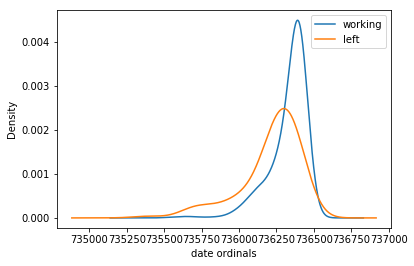

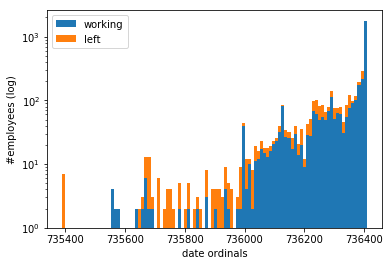

In [209]:
working=attr.groupby('stillExists').get_group(True)['ordinal']
left=attr.groupby('stillExists').get_group(False)['ordinal']
working.plot(kind='density',bw_method=.5)
left.plot(kind='density',bw_method=.5)
plt.legend(['working','left'])
plt.xlabel('date ordinals')
plt.show()

plt.hist([working,left],stacked=True,log='y',bins=100)
plt.xlabel('date ordinals')
plt.ylabel('#employees (log)')
plt.legend(['working','left']);

Clearly, the further back the last date of participation is, the more likely the employee is to have left.

## How many votes does each employee make?

mean: 50.3531009507
std dev: 73.1663651824


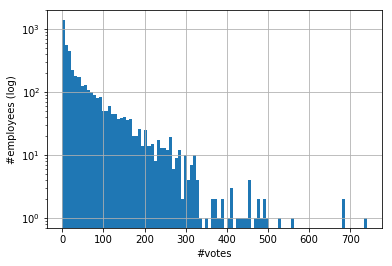

In [226]:
attr.numVotes.hist(bins=100,log='y')
plt.xlabel('#votes')
plt.ylabel('#employees (log)')
print 'mean:',attr.numVotes.mean()
print 'std dev:',attr.numVotes.std()

most employees have very low vote counts. This will make any time series analysis tricky since there aren't many samples to work with. happiness estimates could be taken as averages over all time instead of windowed averages.

## Are the average number of votes dependent on the company?

56aec740f1ef260003e307d6
mean: 75.9036827195
mean: 81.181312316


54d43612e4b0f6a40755d93e
mean: 21.1904761905
mean: 27.7985953739


5370af43e4b0cff95558c12a
mean: 28.2857142857
mean: 44.7674466472


57bb2f0b3bae540003a8d453
mean: 47.7777777778
mean: 45.6292107714


567011c035dce00003a07fa4
mean: 21.8303030303
mean: 31.9850621084


5809cc9eff2ea40003fda44d
mean: 19.6973684211
mean: 20.2464941735


552e2d00e4b066b42fd122ed
mean: 12.1034482759
mean: 14.7777458836


581b08041a0ef8000308aef6
mean: 30.0642857143
mean: 24.6795901212


574c423856b6300003009953
mean: 46.4604316547
mean: 48.8940389638


57908a2622881200033b34d7
mean: 15.0416666667
mean: 26.7931067138


54e52607e4b01191dc064966
mean: 87.6222222222
mean: 120.147066781


57dd2d6a4018d9000339ca43
mean: 53.0950226244
mean: 53.0834251021


57d979b72a040a00036a8925
mean: 10.6111111111
mean: 12.0398304116


5641f96713664c000332c8cd
mean: 102.803571429
mean: 91.0357283911


58b471b384db3200044dd1b9
mean: 6.57142857143
mean: 3.4354326950

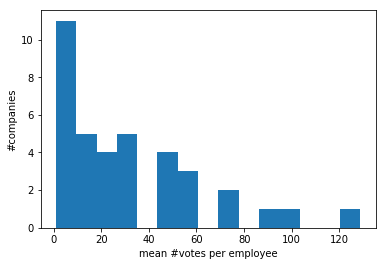

corr coeff: 0.5765644245292082


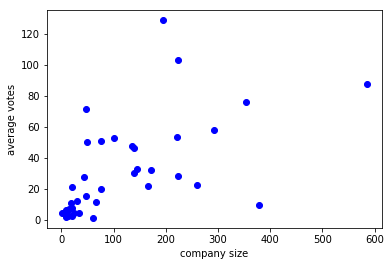

In [289]:
means=[]
for company in companies:
    print company
    print 'mean:',attr.groupby('companyAlias').get_group(company).numVotes.mean()
    print 'mean:',attr.groupby('companyAlias').get_group(company).numVotes.std()
    print '\n'
    means.append(attr.groupby('companyAlias').get_group(company).numVotes.mean())
plt.hist(means,bins=15)
plt.xlabel('mean #votes per employee')
plt.ylabel('#companies')
plt.show()

print 'corr coeff:',np.corrcoef(means,h)[0,1]
plt.plot(h,means,'bo')
plt.xlabel('company size')
plt.ylabel('average votes');

some companies witness lower participation than other companies. this could be because employees in bigger companies are more likely to socialise or because some companies are very new and the numbers haven't had a chance to become higher.

## Does the number of votes cast indicate anything about likelihood of leaving?

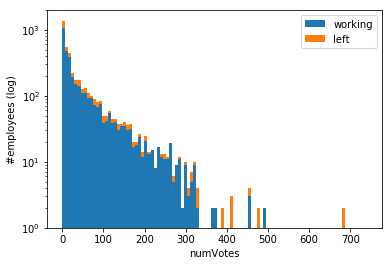

In [245]:
working=attr.groupby('stillExists').get_group(True).numVotes
left=attr.groupby('stillExists').get_group(False).numVotes
plt.hist([working, left],stacked=True,bins=100,log='y')
plt.xlabel('numVotes')
plt.ylabel('#employees (log)')
plt.legend(['working','left']);



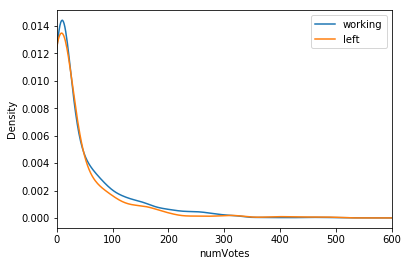

In [238]:
working.plot.kde()
left.plot.kde()
plt.xlabel('numVotes')
plt.xlim([0,600])
plt.legend(['working','left']);

The number of votes by an employee doesn't seem to indicate anything about likelihood of leaving ie unhappy employees are just as likely to vote as happy ones.

## Comments per employee

56aec740f1ef260003e307d6
numComments: 10187, numEmployees: 270, comments per employee: 37.7296296296
54d43612e4b0f6a40755d93e
numComments: 351, numEmployees: 15, comments per employee: 23.4
5370af43e4b0cff95558c12a
numComments: 1683, numEmployees: 60, comments per employee: 28.05
57bb2f0b3bae540003a8d453
numComments: 2854, numEmployees: 106, comments per employee: 26.9245283019
567011c035dce00003a07fa4
numComments: 1939, numEmployees: 113, comments per employee: 17.1592920354
5809cc9eff2ea40003fda44d
numComments: 974, numEmployees: 61, comments per employee: 15.9672131148
552e2d00e4b066b42fd122ed
numComments: 250, numEmployees: 18, comments per employee: 13.8888888889
581b08041a0ef8000308aef6
numComments: 2746, numEmployees: 107, comments per employee: 25.6635514019
574c423856b6300003009953
numComments: 2833, numEmployees: 88, comments per employee: 32.1931818182
57908a2622881200033b34d7
numComments: 947, numEmployees: 34, comments per employee: 27.8529411765
54e52607e4b01191dc064966
n

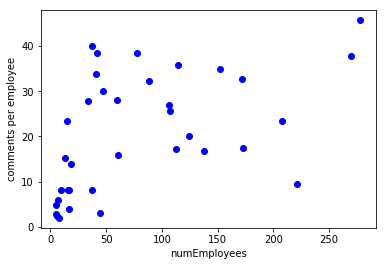

In [259]:
x,y=[],[]
for company in companies:
    try:
        df=mapping.groupby('companyAlias').get_group(company)
        employees=df.employee.unique()
        print company
        print 'numComments: {}, numEmployees: {}, comments per employee: {}'.format(df.shape[0],employees.shape[0],df.shape[0]/float(employees.shape[0]))
        x.append(employees.shape[0])
        y.append(df.shape[0]/float(employees.shape[0]))
    except:pass
plt.plot(x,y,'bo')
plt.xlabel('numEmployees')
plt.ylabel('comments per employee');
print 'corr coeff:',np.corrcoef(x,y)[1,0]

There is a clear correlation between company size and comments made per employee

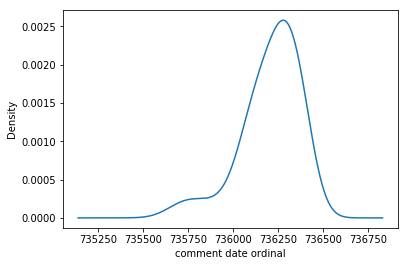

In [265]:
mapping.ordinal.plot.kde(bw_method=0.5)
plt.xlabel('comment date ordinal');

This seems to mirror the last participation date density. number of comments probably just mirrors the number of workers in the system at any time.

## How does happiness vary with company?

overall vote average: 2.86152997758
56aec740f1ef260003e307d6 average: 3.23647032441
54d43612e4b0f6a40755d93e average: 2.9185520362
5370af43e4b0cff95558c12a average: 3.03770283169
57bb2f0b3bae540003a8d453 average: 2.85581395349
567011c035dce00003a07fa4 average: 2.64353137146
5809cc9eff2ea40003fda44d average: 2.69071476286
552e2d00e4b066b42fd122ed average: 2.88034188034
581b08041a0ef8000308aef6 average: 2.4874879692
574c423856b6300003009953 average: 3.36844562004
57908a2622881200033b34d7 average: 3.50969529086
54e52607e4b01191dc064966 average: 2.59181045583
57dd2d6a4018d9000339ca43 average: 3.00264189535
57d979b72a040a00036a8925 average: 3.41884816754
5641f96713664c000332c8cd average: 2.80141597533
58b471b384db3200044dd1b9 average: 2.6847826087
56fd2b64f41c670003f643c8 average: 2.64332375229
5474b9cde4b0bf7614b2c66f average: 3.45652173913
56558cfd07a5de00030908fb average: 2.96428571429
57c4aa7dbb8b5c000396fd3b average: 3.47531607465
56e2a905e3b6fe0003e32855 average: 2.84383766598
57fcf18

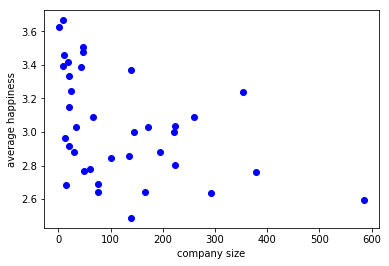

In [298]:
print 'overall vote average: {}'.format(hap.vote.mean())
x,y=[],[]
for company in companies:
    try: 
        print '{} average: {}'.format(company,hap[hap.companyAlias == company].vote.mean())
        x.append((attr.companyAlias==company).sum())
        y.append(hap[hap.companyAlias == company].vote.mean())
    except:pass
print 'corr coeff: ',np.corrcoef(x,y)[0,1]
plt.plot(x,y,'bo')
plt.xlabel('company size')
plt.ylabel('average happiness');

The plot shows a distinct negative correlation of company size with employee happiness. 

## How much time between votes?

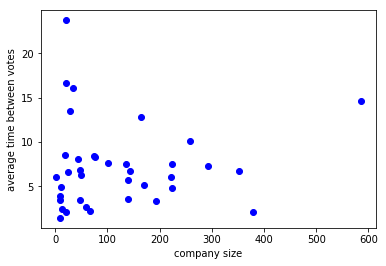

corr coeff:  0.06228331496742335
number of employees who voted only once:  458


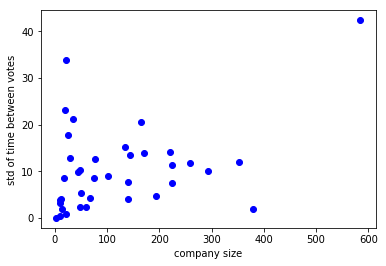

In [349]:
cmps=hap.groupby('companyAlias')
x,y,y2=[],[],[]
temp=0
for company in companies:
    try:
        a=[]
        cp=cmps.get_group(company)
        employees=cp.employee.unique()
        times=cp.groupby('employee')
        for emp in employees:
            v=times.get_group(emp).ordinal
            if v.shape[0]>1:
                a.append(v.diff(1).dropna().mean())
            else: temp+=1
        y2.append(np.std(a))
        y.append(np.mean(a))
        x.append((attr.companyAlias==company).sum())
    except:pass
plt.plot(x,y,'bo')
plt.xlabel('company size')
plt.ylabel('average time between votes')
plt.show()

print 'corr coeff: ',np.corrcoef(x,y)[0,1]
print 'number of employees who voted only once: ',temp

plt.plot(x,y2,'bo')
plt.xlabel('company size')
plt.ylabel('std of time between votes')
plt.show()



a low correlation suggests that company size does not seem to affect the average time or variance of times between votes.